In [31]:
# Make a class wich had a list of lists as an attribute, and a method that deletes the older elements of the list when it gets new ones

class ListOfLists:
    def __init__(self, list_of_lists):
        self.list_of_lists = list_of_lists

    def add_list(self, new_list):
        self.list_of_lists.append(new_list)
        self.list_of_lists = self.list_of_lists[-1:]

    def __str__(self):
        return str(self.list_of_lists)

lol = ListOfLists([[1, 2, 3], [4, 5, 6], [7, 8, 9]])




In [32]:
lol.add_list([10, 11, 12])
print(lol)

[[10, 11, 12]]


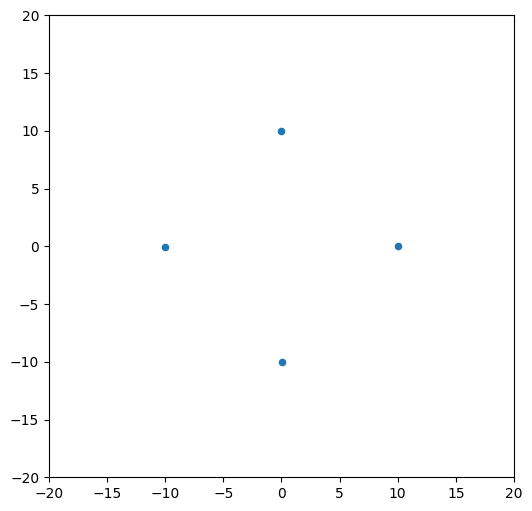

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

class Body:
    def __init__(self, mass, position, velocity):
        self.mass = mass
        self.position = np.array(position, dtype=float)
        self.velocity = np.array(velocity, dtype=float)
        self.force = np.zeros(2)

    def update_position(self, dt):
        self.velocity += self.force / self.mass * dt
        self.position += self.velocity * dt

    def reset_force(self):
        self.force = np.zeros(2)

class QuadTree:
    def __init__(self, x0, y0, size):
        self.x0, self.y0 = x0, y0
        self.size = size
        self.mass = 0
        self.center_of_mass = np.zeros(2)
        self.body = None
        self.children = []

    def insert(self, body):
        if self.body is None and not self.children:
            self.body = body
            self.mass = body.mass
            self.center_of_mass = body.position
        elif not self.children:
            self.subdivide()
            self.children[self.get_quadrant(self.body.position)].insert(self.body)
            self.children[self.get_quadrant(body.position)].insert(body)
            self.body = None
        else:
            self.children[self.get_quadrant(body.position)].insert(body)
        
        self.update_mass_and_center_of_mass()

    def get_quadrant(self, pos):
        if pos[0] < self.x0 and pos[1] < self.y0:
            return 0
        elif pos[0] >= self.x0 and pos[1] < self.y0:
            return 1
        elif pos[0] < self.x0 and pos[1] >= self.y0:
            return 2
        else:
            return 3

    def subdivide(self):
        half_size = self.size / 2
        self.children = [
            QuadTree(self.x0 - half_size / 2, self.y0 - half_size / 2, half_size),
            QuadTree(self.x0 + half_size / 2, self.y0 - half_size / 2, half_size),
            QuadTree(self.x0 - half_size / 2, self.y0 + half_size / 2, half_size),
            QuadTree(self.x0 + half_size / 2, self.y0 + half_size / 2, half_size)
        ]

    def update_mass_and_center_of_mass(self):
        total_mass = 0
        weighted_position = np.zeros(2)
        for child in self.children:
            if child.mass > 0:
                total_mass += child.mass
                weighted_position += child.mass * child.center_of_mass
        if total_mass > 0:
            self.mass = total_mass
            self.center_of_mass = weighted_position / total_mass

    def calculate_force(self, body, theta=0.5, G=6.67430e-11):
        if self.body is not None and self.body != body:
            return self.calculate_direct_force(body, G)
        elif self.children:
            d = np.linalg.norm(self.center_of_mass - body.position)
            if self.size / d < theta:
                return self.calculate_direct_force(body, G)
            else:
                force = np.zeros(2)
                for child in self.children:
                    if child.mass > 0:
                        force += child.calculate_force(body, theta, G)
                return force
        return np.zeros(2)

    def calculate_direct_force(self, body, G):
        direction = self.center_of_mass - body.position
        distance = np.linalg.norm(direction) + 1e-9
        force_magnitude = G * self.mass * body.mass / distance**2
        return force_magnitude * direction / distance

def simulate(bodies, num_steps, dt, bounds_size):
    positions = []
    for step in range(num_steps):
        tree = QuadTree(0, 0, bounds_size)
        for body in bodies:
            tree.insert(body)

        for body in bodies:
            body.reset_force()
            body.force = tree.calculate_force(body)

        for body in bodies:
            body.update_position(dt)

        # Store positions for animation
        positions.append([body.position.copy() for body in bodies])

    return positions

def animate_bodies(bodies, positions, bounds_size):
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set_xlim(-bounds_size, bounds_size)
    ax.set_ylim(-bounds_size, bounds_size)
    scat = ax.scatter([body.position[0] for body in bodies],
                      [body.position[1] for body in bodies],
                      s=20)

    def update(frame):
        scat.set_offsets(positions[frame])
        return scat,

    anim = FuncAnimation(fig, update, frames=len(positions), interval=50, blit=True)
    plt.show()

# Example setup
bodies = [
    Body(mass=5e10, position=[-10, 0], velocity=[0, -2]),
    Body(mass=5e10, position=[10, 0], velocity=[0, 2]),
    Body(mass=5e10, position=[0, -10], velocity=[2, 0]),
    Body(mass=5e10, position=[0, 10], velocity=[-2, 0])
]

# Run the simulation and get positions for animation
positions = simulate(bodies, num_steps=500, dt=0.01, bounds_size=20)

# Animate the bodies
animate_bodies(bodies, positions, bounds_size=20)
